In [2]:
import pandas as pd 
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt 
from sklearn.ensemble import GradientBoostingRegressor
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
%matplotlib inline 
import numpy as np
plt.rcParams['figure.figsize'] = (16, 4)

import warnings
warnings.filterwarnings(action="ignore")
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

#from utils import * # We've added all the functions from the last BLU to the utils.py 

In [3]:
import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

In [4]:
wf1_df = pd.read_csv('data/wf1_data.csv')  
wf2_df = pd.read_csv('data/wf2_data.csv')  
wf3_df = pd.read_csv('data/wf3_data.csv')

In [5]:
wf1_df['date'] = pd.to_datetime(wf1_df.date, format='%Y%m%d%H')
wf2_df['date'] = pd.to_datetime(wf2_df.date, format='%Y%m%d%H')
wf3_df['date'] = pd.to_datetime(wf3_df.date, format='%Y%m%d%H')

In [6]:
wf1_df = wf1_df.set_index('date',    # <---- Set the index to be our timestamp data  
                      drop=True)
wf2_df = wf2_df.set_index('date',    # <---- Set the index to be our timestamp data  
                      drop=True)
wf3_df = wf3_df.set_index('date',    # <---- Set the index to be our timestamp data  
                      drop=True)

In [7]:
data_wf1 = wf1_df[:-24]
vtp_wf1 = wf1_df[-24:]

data_wf2 = wf2_df[:-24]
vtp_wf2 = wf2_df[-24:]

data_wf3 = wf3_df[:-24]
vtp_wf3 = wf3_df[-24:]

In [10]:
vtp_wf1

,wp,ws
date,,
2010-06-30 00:00:00,NaN,6.59
2010-06-30 01:00:00,NaN,5.50
2010-06-30 02:00:00,NaN,4.51
2010-06-30 03:00:00,NaN,3.82
2010-06-30 04:00:00,NaN,3.55
2010-06-30 05:00:00,NaN,3.52
2010-06-30 06:00:00,NaN,3.54
2010-06-30 07:00:00,NaN,3.47
2010-06-30 08:00:00,NaN,3.44


In [8]:
#data_limit = 720  #30 days * 24h
data_limit = 2160 #30 days * 24h * 3 months

In [9]:
data_wf3_r = data_wf3.resample('1H').mean()
missing_values3 = data_wf3_r[data_wf3_r.isnull()['wp']]

In [10]:
from sklearn.impute import KNNImputer
imputer = KNNImputer() # To obtain better results we may want to have more neighbors, of course that in a real setting
                       # this is a parameter that should be tunned
    
data_imputed3 = imputer.fit_transform(data_wf3_r) # This may take a bit to run
data_wf3_imputed2 = pd.DataFrame(data_imputed3, index=data_wf3_r.index, columns=data_wf3_r.columns)
data_wf3_imputed2

,wp,ws
date,,
2009-07-01 01:00:00,0.105000,3.810000
2009-07-01 02:00:00,0.033000,3.680000
2009-07-01 03:00:00,0.022000,3.660000
2009-07-01 04:00:00,0.039000,3.700000
2009-07-01 05:00:00,0.257337,4.333266
...,...,...
2010-06-29 19:00:00,0.468000,9.970000
2010-06-29 20:00:00,0.661000,9.860000
2010-06-29 21:00:00,0.485000,9.480000


In [11]:
def build_some_features(df_, num_periods_lagged=1, num_periods_diffed=0, weekday=False, month=False, hour=False,rolling=[], holidays=False):
    """
    Builds some features by calculating differences between periods
    """
    # make a copy
    df_ = df_.copy()
    # for a few values, get the lags
    for i in range(1, num_periods_lagged+1):
        # make a new feature, with the lags in the observed values column
        df_['lagged_%s' % str(i)] = df_['wp'].shift(i)
    # for a few values, get the diffs
    for i in range(1, num_periods_diffed+1):
        # make a new feature, with the lags in the observed values column
        df_['diff_%s' % str(i)] = df_['wp'].diff(i)
    for stat in rolling:
        df_['rolling_%s'%str(stat)] = df_['wp'].rolling('7D').aggregate(stat)
    if weekday == True:
        df_['sin_weekday'] = np.sin(2*np.pi*df_.index.weekday/7)
        df_['cos_weekday'] = np.cos(2*np.pi*df_.index.weekday/7)
    if month == True:
        df_['sin_month'] = np.sin(2*np.pi*df_.index.month/12)
        df_['cos_month'] = np.cos(2*np.pi*df_.index.month/12)
    if hour == True:
        df_['sin_hour'] = np.sin(2*np.pi*df_.index.hour/12)
        df_['cos_hour'] = np.cos(2*np.pi*df_.index.hour/12)
        
    if holidays == True:
        holidays = df_[((df_.index.month==12) & (df_.index.day==25))
              |((df_.index.month==1) & (df_.index.day==1))].wp
        df_['holidays'] = holidays + 1
        df_['holidays'] = df_['holidays'].fillna(0)
    return df_

In [12]:
data_wf3_imputed = build_some_features(data_wf3_imputed2,
                                       num_periods_lagged=24,
                                       num_periods_diffed=0, 
                                       weekday=True, 
                                       month=True, 
                                       hour=True,rolling=[],
                                       holidays=False)

data_wf3_imputed = data_wf3_imputed.dropna(axis=0)

data_wf3_imputed['rolling_max'] = data_wf3_imputed['wp'].rolling('24h').max().fillna(0)
data_wf3_imputed['rolling_min'] = data_wf3_imputed['wp'].rolling('24h').min().fillna(0)
data_wf3_imputed['rolling_mean'] = data_wf3_imputed['wp'].rolling('24h').mean().fillna(0)
data_wf3_imputed['rolling_std'] = data_wf3_imputed['wp'].rolling('24h').std().fillna(0)

data_wf3_imputed.head()

,wp,ws,lagged_1,lagged_2,lagged_3,lagged_4,lagged_5,lagged_6,lagged_7,lagged_8,...,sin_weekday,cos_weekday,sin_month,cos_month,sin_hour,cos_hour,rolling_max,rolling_min,rolling_mean,rolling_std
date,,,,,,,,,,,,,,,,,,,,,
2009-07-02 01:00:00,0.0,1.15,0.0,0.0,0.257337,0.033000,0.050000,0.257337,0.000000,0.257337,...,0.433884,-0.900969,-0.5,-0.866025,0.500000,8.660254e-01,0.0,0.0,0.0,0.0
2009-07-02 02:00:00,0.0,0.80,0.0,0.0,0.000000,0.257337,0.033000,0.050000,0.257337,0.000000,...,0.433884,-0.900969,-0.5,-0.866025,0.866025,5.000000e-01,0.0,0.0,0.0,0.0
2009-07-02 03:00:00,0.0,0.66,0.0,0.0,0.000000,0.000000,0.257337,0.033000,0.050000,0.257337,...,0.433884,-0.900969,-0.5,-0.866025,1.000000,6.123234e-17,0.0,0.0,0.0,0.0
2009-07-02 04:00:00,0.0,0.63,0.0,0.0,0.000000,0.000000,0.000000,0.257337,0.033000,0.050000,...,0.433884,-0.900969,-0.5,-0.866025,0.866025,-5.000000e-01,0.0,0.0,0.0,0.0
2009-07-02 05:00:00,0.0,0.56,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.257337,0.033000,...,0.433884,-0.900969,-0.5,-0.866025,0.500000,-8.660254e-01,0.0,0.0,0.0,0.0


In [13]:
data_wf3_imputed = data_wf3_imputed.sort_index()
data3 = data_wf3_imputed
ws3 = data3.drop(['wp'],axis = 1)
data3 = data3['wp'] #data3.drop(['ws'],axis = 1)
#data3.plot()

In [14]:
data3_c = data3
ws3_c = ws3

In [15]:
#data3_s = data3_c[-data_limit:]
#ws3_s = ws3_c[-data_limit:]
data3_s = data3_c
ws3_s = ws3_c

In [16]:
data3_t_s = data3_s[:-24]
data3_test_s = data3_s[-24:]

data3_val_s = data3_t_s[-24:]
data3_train_s = data3_t_s[:-24]
 
ws3_t_s = ws3_s[:-24]
ws3_test_s = ws3_s[-24:]

ws3_val_s = ws3_t_s[-24:]
ws3_train_s = ws3_t_s[:-24]

In [17]:
sarimax_pipeline_exog = Pipeline([  #The boxcox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])
#                           m=24, 


sarimax_pipeline_exog.fit(data3_t_s,ws3_t_s)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-42316.113, Time=5.38 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-32080.026, Time=3.71 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-47202.066, Time=2.74 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-36234.724, Time=4.51 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=36189.333, Time=2.50 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-46672.272, Time=3.58 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-43692.565, Time=3.60 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-43834.970, Time=4.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-47218.428, Time=3.52 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-46704.607, Time=3.55 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-43723.052, Time=4.74 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-36239.181, Time=4.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-43899.360, Time=3.99 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 50.277 seco

Pipeline(steps=[('arima',
                 AutoARIMA(maxiter=20, method='nm', suppress_warnings=True,
                           trace=True))])

In [18]:
wf3_predict = sarimax_pipeline_exog.predict(24,ws3_test_s)

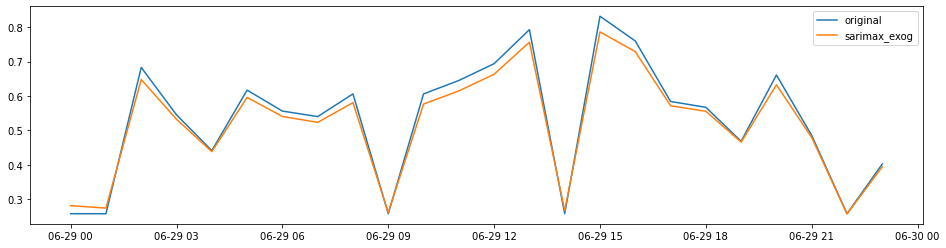

In [19]:
plt.plot(data3_test_s, label='original')
plt.plot(data3_test_s.index, wf3_predict, label='sarimax_exog')
plt.legend()

In [20]:
data_wf2_r = data_wf2.resample('1H').mean()
missing_values2 = data_wf2_r[data_wf2_r.isnull()['wp']]

imputer = KNNImputer() # To obtain better results we may want to have more neighbors, of course that in a real setting
                       # this is a parameter that should be tunned
    
data_imputed2 = imputer.fit_transform(data_wf2_r) # This may take a bit to run
data_wf2_imputed = pd.DataFrame(data_imputed2, index=data_wf2_r.index, columns=data_wf2_r.columns)
data_wf2_imputed2 = data_wf2_imputed.sort_index()

data_wf2_imputed = build_some_features(data_wf2_imputed2,
                                       num_periods_lagged=24,
                                       num_periods_diffed=0, 
                                       weekday=True, 
                                       month=True, 
                                       hour=True,rolling=[],
                                       holidays=False)

data_wf2_imputed = data_wf2_imputed.dropna(axis=0)
data_wf2_imputed['rolling_max'] = data_wf2_imputed['wp'].rolling('24h').max().fillna(0)
data_wf2_imputed['rolling_min'] = data_wf2_imputed['wp'].rolling('24h').min().fillna(0)
data_wf2_imputed['rolling_mean'] = data_wf2_imputed['wp'].rolling('24h').mean().fillna(0)
data_wf2_imputed['rolling_std'] = data_wf2_imputed['wp'].rolling('24h').std().fillna(0)



data2 = data_wf2_imputed
#ws2 = data2['ws']

ws2 = data2.drop(['wp'],axis = 1)
data2 = data2['wp']

data2_c = data2
ws2_c = ws2
#data2_s = data2_c[-data_limit:]
#ws2_s = ws2_c[-data_limit:]
data2_s = data2_c
ws2_s = ws2_c
data2_t_s = data2_s[:-24]
data2_test_s = data2_s[-24:]

data2_val_s = data2_t_s[-24:]
data2_train_s = data2_t_s[:-24]
 
ws2_t_s = ws2_s[:-24]
ws2_test_s = ws2_s[-24:]

ws2_val_s = ws2_t_s[-24:]
ws2_train_s = ws2_t_s[:-24]

sarimax_pipeline_exog = Pipeline([  #The boxcox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])

sarimax_pipeline_exog.fit(data2_t_s,ws2_t_s)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-64345.951, Time=4.98 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-54921.837, Time=2.73 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-70688.089, Time=2.88 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-60480.324, Time=3.64 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13363.352, Time=4.31 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-69055.712, Time=4.24 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-65066.834, Time=3.81 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-64627.215, Time=4.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-70695.316, Time=3.93 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-69058.599, Time=3.69 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-65068.854, Time=5.21 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-60458.876, Time=4.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-64629.200, Time=5.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 52.727 seco

Pipeline(steps=[('arima',
                 AutoARIMA(maxiter=20, method='nm', suppress_warnings=True,
                           trace=True))])

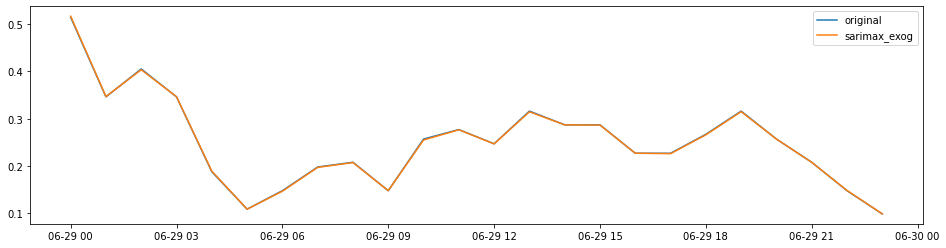

In [21]:
wf2_predict = sarimax_pipeline_exog.predict(24,ws2_test_s)
plt.plot(data2_test_s, label='original')
plt.plot(data2_test_s.index, wf2_predict, label='sarimax_exog')
plt.legend()

In [22]:
#####################
#predictions = np.exp(sarimax.predict_in_sample())
#mae = mean_absolute_error(wf2_predict,emissions_train)

#print(mae)
#####################

In [25]:
data_wf1_r = data_wf1.resample('1H').mean()
missing_values1 = data_wf1_r[data_wf1_r.isnull()['wp']]

imputer = KNNImputer() # To obtain better results we may want to have more neighbors, of course that in a real setting
                       # this is a parameter that should be tunned
    
data_imputed1 = imputer.fit_transform(data_wf1_r) # This may take a bit to run
data_wf1_imputed = pd.DataFrame(data_imputed1, index=data_wf1_r.index, columns=data_wf1_r.columns)
data_wf1_imputed2 = data_wf1_imputed.sort_index()


data_wf1_imputed = build_some_features(data_wf1_imputed2,
                                       num_periods_lagged=24,
                                       num_periods_diffed=0, 
                                       weekday=True, 
                                       month=True, 
                                       hour=True,rolling=[],
                                       holidays=False)

data_wf1_imputed = data_wf1_imputed.dropna(axis=0)

data_wf1_imputed['rolling_max'] = data_wf1_imputed['wp'].rolling('24h').max().fillna(0)
data_wf1_imputed['rolling_min'] = data_wf1_imputed['wp'].rolling('24h').min().fillna(0)
data_wf1_imputed['rolling_mean'] = data_wf1_imputed['wp'].rolling('24h').mean().fillna(0)
data_wf1_imputed['rolling_std'] = data_wf1_imputed['wp'].rolling('24h').std().fillna(0)



data1 = data_wf1_imputed
#ws1 = data1.drop(['wp'],axis = 1)

ws1 = data1.drop(['wp'],axis = 1)
data1 = data1['wp']

data1_c = data1
ws1_c = ws1
data1_s = data1_c #[-data_limit:]
ws1_s = ws1_c #[-data_limit:]
data1_t_s = data1_s[:-24]
data1_test_s = data1_s[-24:]

data1_val_s = data1_t_s[-24:]
data1_train_s = data1_t_s[:-24]
 
ws1_t_s = ws1_s[:-24]
ws1_test_s = ws1_s[-24:]

ws1_val_s = ws1_t_s[-24:]
ws1_train_s = ws1_t_s[:-24]

sarimax_pipeline_exog = Pipeline([  #The boxcox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])

sarimax_pipeline_exog.fit(data1_t_s,ws1_t_s)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-28441.012, Time=4.60 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-72259.149, Time=2.81 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-47538.945, Time=2.72 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-15871.861, Time=3.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3948.589, Time=2.80 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-54790.978, Time=3.58 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 20.103 seconds


Pipeline(steps=[('arima',
                 AutoARIMA(maxiter=20, method='nm', suppress_warnings=True,
                           trace=True))])

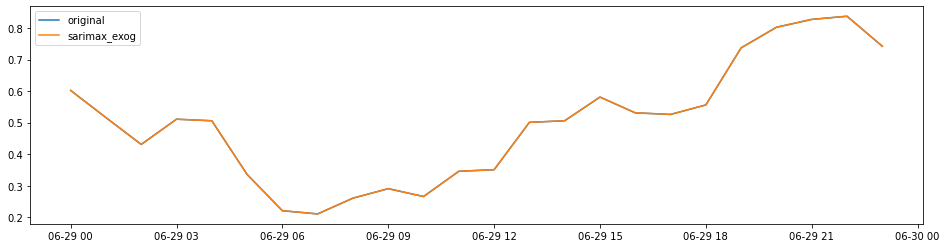

In [26]:
wf1_predict = sarimax_pipeline_exog.predict(24,ws1_test_s)
plt.plot(data1_test_s, label='original')
plt.plot(data1_test_s.index, wf1_predict, label='sarimax_exog')
plt.legend()

In [27]:
generate_submission_file(wf1_predict , wf2_predict , wf3_predict)

,value
0,0.601976
1,0.516233
2,0.431196
3,0.510856
4,0.505959
...,...
19,0.465742
20,0.632502
21,0.479010
22,0.256738
